In [1]:
import torch
from sentence_transformers import SentenceTransformer, models
from custom_sentence_transformers import CustomSentenceTransformer
from torch import nn

word_embedding_model = models.Transformer("sentence-transformers/distiluse-base-multilingual-cased-v1", max_seq_length=512)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())

model = CustomSentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model], device='cuda')
model.to('cuda')
model

In [1]:
import pandas as pd

dataset = pd.read_parquet("../dataset/train_math_exercice.parquet")
dataset

,problem,level,type,solution,id,source,category
0,Find the positive base $b$ in which the equati...,Level 4,Number Theory,When we rewrite the above equation with the ba...,number_theory_1004,test,4
1,There are eight boys and six girls who are mem...,Level 3,Counting & Probability,"First, we consider how many ways there are to ...",counting_and_probability_682,test,1
2,What is the domain of the function $g(x) = \fr...,Level 1,Intermediate Algebra,The formula for $g(x)$ has a defined value unl...,intermediate_algebra_1317,train,3
3,"A standard deck of 52 cards has 13 ranks (Ace,...",Level 3,Prealgebra,There are $3 \times 4 = 12$ face cards and 52 ...,prealgebra_1079,test,5
4,"The two endpoints of a segment are at $(1,4)$ ...",Level 1,Algebra,The midpoint of the segment is at $\left(\frac...,algebra_1025,test,0
...,...,...,...,...,...,...,...
9995,Given that 0.5 liters is approximately 1.05 pi...,Level 3,Prealgebra,"If half a liter is 1.05 pints, then a whole li...",prealgebra_532,train,5
9996,"In the figure shown, $AC=13$ and $DC=2$ units....",Level 4,Geometry,"Since $AC=AD+DC=13$ and $DC=2$, $AD=11$. We al...",geometry_953,test,2
9997,There are eight furlongs in a mile. There are ...,Level 4,Prealgebra,We have \[\n14\text{ days} = 1 \text{ fortnig...,prealgebra_1260,test,5
9998,"If a rectangular prism has a length of $l$, a ...",Level 2,Algebra,We are given that $$\sqrt{l^2 + w^2 + h^2} = \...,algebra_676,train,0


In [3]:
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, InputExample
from torch.utils.data import DataLoader

train_examples = []
for i, sample in dataset.iterrows():
    cat = sample['category']
    pos_example = dataset.loc[dataset['category']==cat].sample(n=1).iloc[0]
    neg_example = dataset.loc[dataset['category']!=cat].sample(n=1).iloc[0]
    train_examples.append(InputExample(texts=[sample["problem"], pos_example["problem"]], label=1))
    train_examples.append(InputExample(texts=[sample["problem"], neg_example["problem"]], label=0))
   


In [ ]:
from IPython.display import display, Latex

for i in range(20):
    print(i, train_examples[i].label)
    print("-"*50)
    display(Latex(train_examples[i].texts[0]))
    print("-"*50)
    display(Latex(train_examples[i].texts[1]))
    print("="*100)

In [ ]:
model.to('cuda')
model.device

In [ ]:
from sentence_transformers import losses, InputExample
from torch.utils.data import DataLoader

BATCH_SIZE = 4

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)
train_loss = losses.ContrastiveLoss(
    model=model, 
    distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE,
    margin=1.0,
)

In [ ]:
print(train_loss.margin)
print(train_loss.model.device)
train_loss.distance_metric

In [ ]:
#Tune the model (17:34 - 17:54 -> 20 min)
model.fit(
    train_objectives=[(train_dataloader, train_loss)], 
    epochs=1, 
    warmup_steps=100,
    gradient_accumulation_steps=4,
    show_progress_bar=True,
    checkpoint_path = "../models/ckpt/sbert-math-problem-ContrastiveLoss-cuda/",
    checkpoint_save_steps = 2000,
    checkpoint_save_total_limit = 1
)

In [ ]:
model.save("../models/sbert-math-problem-ContrastiveLoss-cuda/")

In [2]:
# to load the already trained model
"""import torch
from sentence_transformers import SentenceTransformer, models
from custom_sentence_transformers import CustomSentenceTransformer
from torch import nn

model = SentenceTransformer("../models/sbert-math-problem-ContrastiveLoss-cuda/", device='cpu')
model.to('cuda')
model
"""

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [3]:
BATCH_SIZE = 32

dataset["sentence_embedding"] = pd.Series(
        model.encode(dataset["problem"], batch_size=BATCH_SIZE, device='cuda', show_progress_bar=True).tolist()
    )

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [4]:
import numpy as np
from scipy.spatial.distance import cosine

def cosine_similarity(vec_a, vec_b) -> float:
        return 1 - cosine(
            np.array(vec_a).reshape(1, -1)[0],
            np.array(vec_b).reshape(1, -1)[0],
        )

identical_category_scores = []
different_category_scores = []

for i, sample in dataset.iterrows():
    cat = sample['category']
    
    pos_example = dataset.loc[dataset['category']==cat].sample(n=1).iloc[0]
    identical_category_scores.append(cosine_similarity(sample["sentence_embedding"], pos_example["sentence_embedding"]))
    
    neg_example = dataset.loc[dataset['category']!=cat].sample(n=1).iloc[0]
    different_category_scores.append(cosine_similarity(sample["sentence_embedding"], neg_example["sentence_embedding"]))
    

Jensen-Shannon distance:  0.4732990703058332
Wasserstein distance:  0.5614926859106303


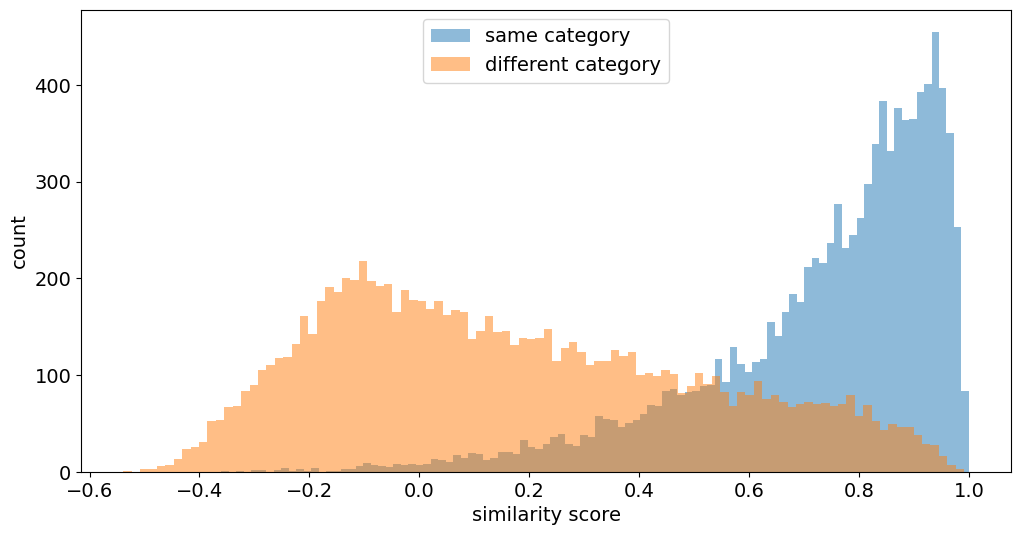

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import wasserstein_distance


print("Jensen-Shannon distance: ", distance.jensenshannon(np.clip(identical_category_scores, 0.001, None), np.clip(different_category_scores, 0.001, None)))
print("Wasserstein distance: ", wasserstein_distance(identical_category_scores, different_category_scores))

plt.figure(figsize=(12, 6))
plt.hist(np.array(identical_category_scores), alpha=0.5, bins=100, label="same category")
plt.hist(np.array(different_category_scores), alpha=0.5, bins=100, label="different category")
plt.ylabel("count", fontsize=14)
plt.xlabel("similarity score", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='upper center', fontsize=14)
plt.savefig("similarity_score_after_training_trainset.png", dpi=600, bbox_inches="tight")
plt.show()

## Dataset Test

In [18]:
dataset_test = pd.read_parquet("../dataset/test_math_exercice.parquet")
dataset_test

,problem,level,type,solution,id,source,category
0,What is the reciprocal of $0.\overline{714285}...,Level 5,Prealgebra,Let's first convert $0.\overline{714285}$ to a...,prealgebra_1148,test,5
1,Given that $\cos a = \frac{1}{3}$ and $\cos b ...,Level 3,Precalculus,"By product-to-sum,\n\[\cos (a + b) \cos (a - b...",precalculus_732,test,6
2,"If $a$ and $b$ are integers with $a > b$, what...",Level 5,Algebra,"Let $x = \frac{a+b}{a-b}$. Then, $\frac{a-b}{a...",algebra_595,train,0
3,Two numbers are said to be 'relatively prime' ...,Level 5,Prealgebra,"Since $28=2^2\cdot 7$, a positive integer is r...",prealgebra_1419,test,5
4,How many positive integers are less than $200\...,Level 2,Prealgebra,Based on our knowledge of the decimal expansio...,prealgebra_1891,test,5
...,...,...,...,...,...,...,...
2495,Define the function $f(x) = 2x - 5$. For what ...,Level 4,Algebra,Substituting $f^{-1}(x)$ into our expression f...,algebra_1450,train,0
2496,One-half of one-seventh of $T$ equals one-thir...,Level 3,Prealgebra,"From the problem, we write the equation \[\fra...",prealgebra_495,train,5
2497,Mr. Madoff invests 1000 dollars in a fund that...,Level 4,Algebra,Let $r$ be the annual interest rate. Then aft...,algebra_1014,test,0
2498,The volume of a cylinder is 60 cubic centimete...,Level 5,Geometry,We begin by drawing a diagram: [asy]\nimport s...,geometry_582,test,2


In [20]:
dataset_test["sentence_embedding"] = pd.Series(
        model.encode(dataset_test["problem"], batch_size=BATCH_SIZE, device='cuda', show_progress_bar=True).tolist()
    )

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

In [24]:
identical_category_scores_test = []
different_category_scores_test = []

for i, sample in dataset_test.iterrows():
    cat = sample['category']
    
    pos_example = dataset_test.loc[dataset_test['category']==cat].sample(n=1).iloc[0]
    identical_category_scores_test.append(cosine_similarity(sample["sentence_embedding"], pos_example["sentence_embedding"]))
    
    neg_example = dataset_test.loc[dataset_test['category']!=cat].sample(n=1).iloc[0]
    different_category_scores_test.append(cosine_similarity(sample["sentence_embedding"], neg_example["sentence_embedding"]))

Jensen-Shannon distance:  0.47053701973524603
Wasserstein distance:  0.5165541549863734


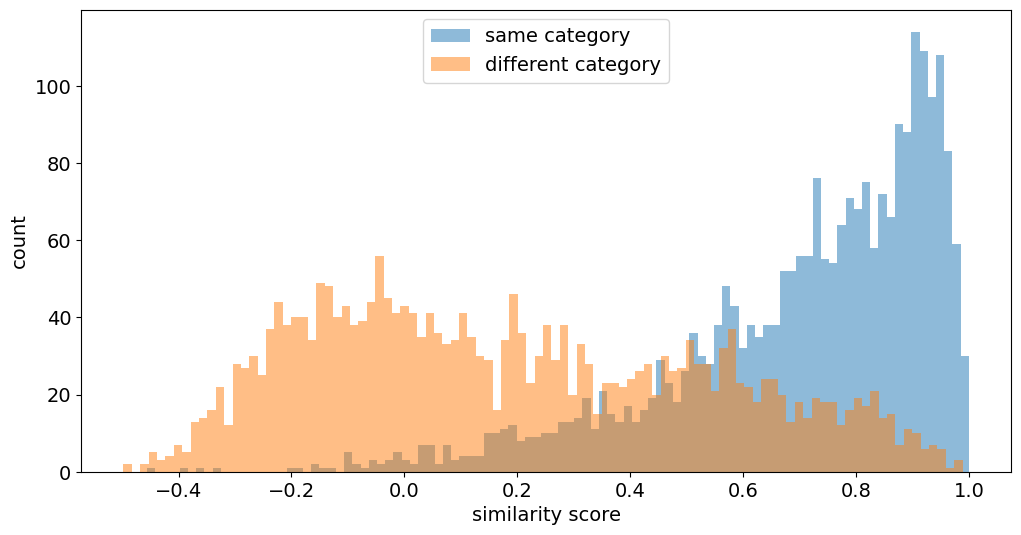

In [25]:
print("Jensen-Shannon distance: ", distance.jensenshannon(np.clip(identical_category_scores_test, 0.001, None), np.clip(different_category_scores_test, 0.001, None)))
print("Wasserstein distance: ", wasserstein_distance(identical_category_scores_test, different_category_scores_test))

plt.figure(figsize=(12, 6))
plt.hist(np.array(identical_category_scores_test), alpha=0.5, bins=100, label="same category")
plt.hist(np.array(different_category_scores_test), alpha=0.5, bins=100, label="different category")
plt.ylabel("count", fontsize=14)
plt.xlabel("similarity score", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='upper center', fontsize=14)
#plt.savefig("similarity_score_after_training_testset.png", dpi=600, bbox_inches="tight")
plt.show()